In [44]:
import numpy as np
import pandas as pd
import matplotlib as plt
import re
import lightgbm as lgb
import datetime as dt
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

In [45]:
borrar = ["Opportunity_Name", "ID", "Brand", "Product_Type", "ASP_converted_Currency", 
          "Prod_Category_A", "Product_Category_B", "Actual_Delivery_Date", "Last_Activity", 
          "ASP_converted_Currency", "Prod_Category_A", "Product_Name", "Delivery_Year", "Month", 
          "TRF", "Product_Family", "Account_Name"]

useless = ["Submitted_for_Approval", "Account_Type", "Delivery_Terms", "Size", "Price", "ASP_Currency", 
           "Total_Amount_Currency", "Total_Taxable_Amount_Currency","Quote_Type", "Opportunity_Type"] # "Product_Category_B", "Region"]

dates = ["Account_Created_Date", "Opportunity_Created_Date", "Quote_Expiry_Date", "Last_Modified_Date", 
         "Planned_Delivery_Start_Date", "Planned_Delivery_End_Date"]

target = ["Opportunity_ID", "Stage", "Sales_Contract_No"]

In [46]:
def preprocess(data):
    
    # elimino caracteres prohibidos en los headers
    
    data = data.rename(columns = lambda x:re.sub("[^A-Za-z0-9_]+", "", x))
        
    for d in dates:
        data[d] = pd.to_datetime(data[d])

    # agrego features
    
    data["Contacts"] = data.groupby("Opportunity_ID", sort = False)["Opportunity_ID"].transform("count")
    data["Delivery_Difference"] = (data["Planned_Delivery_End_Date"] - data["Planned_Delivery_Start_Date"]).dt.days
    data["Same_Owner"] = data.Opportunity_Owner == data.Last_Modified_By
    data["Has_Brand"] = data.Brand != "None"
    data["Has_Contract"] = data.Sales_Contract_No != "None"
    data["Different_Country"] = (data.Billing_Country != data.Territory) & (data.Territory != "None")    
    data.loc[data.TRF == 0, "TRF_Cat"] = 0
    data.loc[(1 <= data.TRF) & (data.TRF <= 7), "TRF_Cat"] = 1
    data.loc[data.TRF > 7, "TRF_Cat"] = 2
    data["Sales"] = data.groupby("Account_Name", sort = False)["Account_Name"].transform("count")
    
    data["Concrete_Offer"] = (data["Planned_Delivery_End_Date"] - data["Opportunity_Created_Date"]).dt.days
    #data.loc[data.Concrete_Offer <= 0, 'Concrete_Offer'] = 0
    data["Offer_Duration"] = (data["Quote_Expiry_Date"] - data["Opportunity_Created_Date"]).dt.days
    #data.loc[data.Offer_Duration <= 0, 'Offer_Duration'] = -1
    
    # fabri
    
    data["Territory_Defined"] = data.Territory != "None"
    data["Past_Quote"] = (data["Last_Modified_Date"] - data["Quote_Expiry_Date"]).dt.days
    #data.loc[(data.Past_Quote <= 100) & (data.Past_Quote > 0), 'Past_Quote'] = 1
    #data.loc[(data.Past_Quote >= -100) & (data.Past_Quote < 0), 'Past_Quote'] = -1
    #data.loc[data.Past_Quote < -100, 'Past_Quote'] = -2
    #data.loc[data.Past_Quote > 100, 'Past_Quote'] = 2
    #data['Past_Quote'].astype('category')
    
    # casteo a categoricas varias columnas
    categorical = [x for x in data.columns if data[x].dtype == "object"]
    for c in categorical:       
        data[c] = data[c].astype('category')
        
    # limpio columnas
    
    data = data.drop(borrar + useless + dates, axis = 1)
    
    #data.drop(data[(data.Contacts > 1) & (data.ASP.isna())].index, inplace = True)
    #data = data.drop_duplicates([x for x in data.columns if x != 'ID'])
    
    return (data)

In [47]:
import catboost as ctb

In [48]:
data = pd.read_csv("Entrenamieto_ECI_2020.csv")

In [49]:
rest = [x for x in data.columns if x != 'ID']
len(data[data.duplicated(rest)])/float(len(data)) * 100

2.643535729037588

In [50]:
prep = preprocess(data)

In [51]:
prep = prep[(prep.Stage == "Closed Won") | (prep.Stage == "Closed Lost")]
prep.Stage = prep.Stage.replace({"Closed Won": 1, "Closed Lost": 0})

In [52]:
len(prep[prep.duplicated()])

481

In [53]:
x_train, x_test, y_train, y_test = train_test_split(prep, prep.Stage, test_size=0.3, random_state=0)

In [54]:
cat_vars = [x for x in x_train.drop(target, axis=1).select_dtypes('category').columns if x != 'Stage']

In [55]:
cat_vars

['Region',
 'Territory',
 'Bureaucratic_Code',
 'Source',
 'Billing_Country',
 'Account_Owner',
 'Opportunity_Owner',
 'Currency',
 'Last_Modified_By',
 'Delivery_Quarter']

In [56]:
cat_indexes = [x_train.drop(target, axis=1).columns.get_loc(x) for x in cat_vars]

In [57]:
cat_indexes

[0, 1, 6, 7, 8, 9, 10, 11, 12, 15]

In [58]:
model = ctb.CatBoostClassifier(num_boost_round=5000,
                               learning_rate=0.015,
                               l2_leaf_reg=3.5,
                               depth=8, 
                               max_bin=400,
                               num_leaves=31,
                               rsm=0.98,
                               eval_metric='Logloss',
                               use_best_model=True,
                               random_seed=42)

In [59]:
model.fit(x_train.drop(target, axis=1), y_train, eval_set=(x_test.drop(target, axis=1), y_test), cat_features=cat_indexes, early_stopping_rounds=800)

0:	learn: 0.6662320	test: 0.6666361	best: 0.6666361 (0)	total: 20.7ms	remaining: 1m 43s
1:	learn: 0.6429421	test: 0.6436226	best: 0.6436226 (1)	total: 39.1ms	remaining: 1m 37s
2:	learn: 0.6216509	test: 0.6225760	best: 0.6225760 (2)	total: 58.5ms	remaining: 1m 37s
3:	learn: 0.5973714	test: 0.5985329	best: 0.5985329 (3)	total: 76.7ms	remaining: 1m 35s
4:	learn: 0.5773562	test: 0.5786428	best: 0.5786428 (4)	total: 94ms	remaining: 1m 33s
5:	learn: 0.5590138	test: 0.5604702	best: 0.5604702 (5)	total: 101ms	remaining: 1m 24s
6:	learn: 0.5404298	test: 0.5413506	best: 0.5413506 (6)	total: 120ms	remaining: 1m 25s
7:	learn: 0.5231761	test: 0.5243156	best: 0.5243156 (7)	total: 129ms	remaining: 1m 20s
8:	learn: 0.5056932	test: 0.5075932	best: 0.5075932 (8)	total: 151ms	remaining: 1m 23s
9:	learn: 0.4882563	test: 0.4904856	best: 0.4904856 (9)	total: 168ms	remaining: 1m 23s
10:	learn: 0.4727450	test: 0.4752240	best: 0.4752240 (10)	total: 179ms	remaining: 1m 21s
11:	learn: 0.4590669	test: 0.4617270	b

93:	learn: 0.1226505	test: 0.1331930	best: 0.1331930 (93)	total: 1.71s	remaining: 1m 29s
94:	learn: 0.1216519	test: 0.1322484	best: 0.1322484 (94)	total: 1.74s	remaining: 1m 29s
95:	learn: 0.1213902	test: 0.1320254	best: 0.1320254 (95)	total: 1.75s	remaining: 1m 29s
96:	learn: 0.1208335	test: 0.1314842	best: 0.1314842 (96)	total: 1.77s	remaining: 1m 29s
97:	learn: 0.1200202	test: 0.1307026	best: 0.1307026 (97)	total: 1.79s	remaining: 1m 29s
98:	learn: 0.1192136	test: 0.1299655	best: 0.1299655 (98)	total: 1.81s	remaining: 1m 29s
99:	learn: 0.1183497	test: 0.1291025	best: 0.1291025 (99)	total: 1.83s	remaining: 1m 29s
100:	learn: 0.1176627	test: 0.1284546	best: 0.1284546 (100)	total: 1.85s	remaining: 1m 29s
101:	learn: 0.1168231	test: 0.1277207	best: 0.1277207 (101)	total: 1.87s	remaining: 1m 29s
102:	learn: 0.1161068	test: 0.1271305	best: 0.1271305 (102)	total: 1.9s	remaining: 1m 30s
103:	learn: 0.1155563	test: 0.1266211	best: 0.1266211 (103)	total: 1.93s	remaining: 1m 30s
104:	learn: 0.

188:	learn: 0.0883254	test: 0.1031789	best: 0.1031789 (188)	total: 3.61s	remaining: 1m 31s
189:	learn: 0.0880793	test: 0.1030143	best: 0.1030143 (189)	total: 3.63s	remaining: 1m 31s
190:	learn: 0.0879498	test: 0.1029357	best: 0.1029357 (190)	total: 3.65s	remaining: 1m 31s
191:	learn: 0.0877724	test: 0.1028046	best: 0.1028046 (191)	total: 3.67s	remaining: 1m 31s
192:	learn: 0.0876039	test: 0.1026542	best: 0.1026542 (192)	total: 3.68s	remaining: 1m 31s
193:	learn: 0.0874722	test: 0.1025465	best: 0.1025465 (193)	total: 3.7s	remaining: 1m 31s
194:	learn: 0.0874217	test: 0.1024939	best: 0.1024939 (194)	total: 3.71s	remaining: 1m 31s
195:	learn: 0.0872750	test: 0.1023800	best: 0.1023800 (195)	total: 3.73s	remaining: 1m 31s
196:	learn: 0.0869755	test: 0.1022054	best: 0.1022054 (196)	total: 3.75s	remaining: 1m 31s
197:	learn: 0.0867328	test: 0.1019683	best: 0.1019683 (197)	total: 3.77s	remaining: 1m 31s
198:	learn: 0.0866681	test: 0.1019598	best: 0.1019598 (198)	total: 3.79s	remaining: 1m 31s


290:	learn: 0.0748581	test: 0.0933075	best: 0.0933075 (290)	total: 5.5s	remaining: 1m 28s
291:	learn: 0.0747668	test: 0.0932483	best: 0.0932483 (291)	total: 5.52s	remaining: 1m 29s
292:	learn: 0.0746664	test: 0.0931797	best: 0.0931797 (292)	total: 5.54s	remaining: 1m 29s
293:	learn: 0.0745969	test: 0.0931359	best: 0.0931359 (293)	total: 5.56s	remaining: 1m 29s
294:	learn: 0.0745454	test: 0.0931019	best: 0.0931019 (294)	total: 5.58s	remaining: 1m 29s
295:	learn: 0.0744149	test: 0.0930113	best: 0.0930113 (295)	total: 5.6s	remaining: 1m 29s
296:	learn: 0.0743781	test: 0.0929723	best: 0.0929723 (296)	total: 5.62s	remaining: 1m 29s
297:	learn: 0.0742052	test: 0.0928257	best: 0.0928257 (297)	total: 5.64s	remaining: 1m 28s
298:	learn: 0.0741626	test: 0.0927818	best: 0.0927818 (298)	total: 5.66s	remaining: 1m 28s
299:	learn: 0.0741392	test: 0.0927801	best: 0.0927801 (299)	total: 5.67s	remaining: 1m 28s
300:	learn: 0.0740962	test: 0.0927307	best: 0.0927307 (300)	total: 5.69s	remaining: 1m 28s
3

386:	learn: 0.0676901	test: 0.0885044	best: 0.0885044 (386)	total: 7.42s	remaining: 1m 28s
387:	learn: 0.0675889	test: 0.0884261	best: 0.0884261 (387)	total: 7.45s	remaining: 1m 28s
388:	learn: 0.0674099	test: 0.0883366	best: 0.0883366 (388)	total: 7.47s	remaining: 1m 28s
389:	learn: 0.0673865	test: 0.0883042	best: 0.0883042 (389)	total: 7.49s	remaining: 1m 28s
390:	learn: 0.0672320	test: 0.0881958	best: 0.0881958 (390)	total: 7.51s	remaining: 1m 28s
391:	learn: 0.0672047	test: 0.0881866	best: 0.0881866 (391)	total: 7.54s	remaining: 1m 28s
392:	learn: 0.0671696	test: 0.0881817	best: 0.0881817 (392)	total: 7.56s	remaining: 1m 28s
393:	learn: 0.0671330	test: 0.0881498	best: 0.0881498 (393)	total: 7.58s	remaining: 1m 28s
394:	learn: 0.0670842	test: 0.0881451	best: 0.0881451 (394)	total: 7.61s	remaining: 1m 28s
395:	learn: 0.0670159	test: 0.0881032	best: 0.0881032 (395)	total: 7.63s	remaining: 1m 28s
396:	learn: 0.0669551	test: 0.0880893	best: 0.0880893 (396)	total: 7.66s	remaining: 1m 28s

477:	learn: 0.0627127	test: 0.0857431	best: 0.0857431 (477)	total: 9.57s	remaining: 1m 30s
478:	learn: 0.0626855	test: 0.0857159	best: 0.0857159 (478)	total: 9.6s	remaining: 1m 30s
479:	learn: 0.0626633	test: 0.0856953	best: 0.0856953 (479)	total: 9.62s	remaining: 1m 30s
480:	learn: 0.0625896	test: 0.0856474	best: 0.0856474 (480)	total: 9.65s	remaining: 1m 30s
481:	learn: 0.0625626	test: 0.0856394	best: 0.0856394 (481)	total: 9.67s	remaining: 1m 30s
482:	learn: 0.0625539	test: 0.0856327	best: 0.0856327 (482)	total: 9.68s	remaining: 1m 30s
483:	learn: 0.0624277	test: 0.0855086	best: 0.0855086 (483)	total: 9.72s	remaining: 1m 30s
484:	learn: 0.0623980	test: 0.0855052	best: 0.0855052 (484)	total: 9.75s	remaining: 1m 30s
485:	learn: 0.0623229	test: 0.0854706	best: 0.0854706 (485)	total: 9.78s	remaining: 1m 30s
486:	learn: 0.0622828	test: 0.0854740	best: 0.0854706 (485)	total: 9.8s	remaining: 1m 30s
487:	learn: 0.0621795	test: 0.0854047	best: 0.0854047 (487)	total: 9.82s	remaining: 1m 30s
4

571:	learn: 0.0582720	test: 0.0830960	best: 0.0830960 (571)	total: 11.5s	remaining: 1m 28s
572:	learn: 0.0582615	test: 0.0830921	best: 0.0830921 (572)	total: 11.5s	remaining: 1m 28s
573:	learn: 0.0582271	test: 0.0830895	best: 0.0830895 (573)	total: 11.5s	remaining: 1m 28s
574:	learn: 0.0581802	test: 0.0830606	best: 0.0830606 (574)	total: 11.5s	remaining: 1m 28s
575:	learn: 0.0580734	test: 0.0830085	best: 0.0830085 (575)	total: 11.5s	remaining: 1m 28s
576:	learn: 0.0580485	test: 0.0829999	best: 0.0829999 (576)	total: 11.6s	remaining: 1m 28s
577:	learn: 0.0580334	test: 0.0829964	best: 0.0829964 (577)	total: 11.6s	remaining: 1m 28s
578:	learn: 0.0579751	test: 0.0829676	best: 0.0829676 (578)	total: 11.6s	remaining: 1m 28s
579:	learn: 0.0579231	test: 0.0829547	best: 0.0829547 (579)	total: 11.6s	remaining: 1m 28s
580:	learn: 0.0578823	test: 0.0829371	best: 0.0829371 (580)	total: 11.6s	remaining: 1m 28s
581:	learn: 0.0578562	test: 0.0829146	best: 0.0829146 (581)	total: 11.6s	remaining: 1m 28s

670:	learn: 0.0534545	test: 0.0801848	best: 0.0801848 (670)	total: 13.8s	remaining: 1m 28s
671:	learn: 0.0534445	test: 0.0801668	best: 0.0801668 (671)	total: 13.8s	remaining: 1m 28s
672:	learn: 0.0533715	test: 0.0801114	best: 0.0801114 (672)	total: 13.8s	remaining: 1m 28s
673:	learn: 0.0533265	test: 0.0800957	best: 0.0800957 (673)	total: 13.9s	remaining: 1m 28s
674:	learn: 0.0532932	test: 0.0800759	best: 0.0800759 (674)	total: 13.9s	remaining: 1m 28s
675:	learn: 0.0532237	test: 0.0800399	best: 0.0800399 (675)	total: 13.9s	remaining: 1m 28s
676:	learn: 0.0532185	test: 0.0800400	best: 0.0800399 (675)	total: 13.9s	remaining: 1m 28s
677:	learn: 0.0532153	test: 0.0800376	best: 0.0800376 (677)	total: 13.9s	remaining: 1m 28s
678:	learn: 0.0531890	test: 0.0800239	best: 0.0800239 (678)	total: 14s	remaining: 1m 28s
679:	learn: 0.0531814	test: 0.0800204	best: 0.0800204 (679)	total: 14s	remaining: 1m 28s
680:	learn: 0.0530713	test: 0.0799421	best: 0.0799421 (680)	total: 14s	remaining: 1m 28s
681:	

770:	learn: 0.0491282	test: 0.0775189	best: 0.0775189 (770)	total: 16.2s	remaining: 1m 28s
771:	learn: 0.0490707	test: 0.0774770	best: 0.0774770 (771)	total: 16.2s	remaining: 1m 28s
772:	learn: 0.0490416	test: 0.0774659	best: 0.0774659 (772)	total: 16.2s	remaining: 1m 28s
773:	learn: 0.0490040	test: 0.0774316	best: 0.0774316 (773)	total: 16.2s	remaining: 1m 28s
774:	learn: 0.0489347	test: 0.0773768	best: 0.0773768 (774)	total: 16.2s	remaining: 1m 28s
775:	learn: 0.0489062	test: 0.0773677	best: 0.0773677 (775)	total: 16.3s	remaining: 1m 28s
776:	learn: 0.0488433	test: 0.0773440	best: 0.0773440 (776)	total: 16.3s	remaining: 1m 28s
777:	learn: 0.0488086	test: 0.0773198	best: 0.0773198 (777)	total: 16.3s	remaining: 1m 28s
778:	learn: 0.0487884	test: 0.0773094	best: 0.0773094 (778)	total: 16.3s	remaining: 1m 28s
779:	learn: 0.0487806	test: 0.0773090	best: 0.0773090 (779)	total: 16.3s	remaining: 1m 28s
780:	learn: 0.0487431	test: 0.0772796	best: 0.0772796 (780)	total: 16.3s	remaining: 1m 28s

867:	learn: 0.0449218	test: 0.0749296	best: 0.0749296 (867)	total: 18.5s	remaining: 1m 28s
868:	learn: 0.0448333	test: 0.0748852	best: 0.0748852 (868)	total: 18.5s	remaining: 1m 28s
869:	learn: 0.0448004	test: 0.0748730	best: 0.0748730 (869)	total: 18.6s	remaining: 1m 28s
870:	learn: 0.0447652	test: 0.0748548	best: 0.0748548 (870)	total: 18.6s	remaining: 1m 28s
871:	learn: 0.0447536	test: 0.0748523	best: 0.0748523 (871)	total: 18.6s	remaining: 1m 28s
872:	learn: 0.0446984	test: 0.0748470	best: 0.0748470 (872)	total: 18.6s	remaining: 1m 28s
873:	learn: 0.0446630	test: 0.0748261	best: 0.0748261 (873)	total: 18.7s	remaining: 1m 28s
874:	learn: 0.0446315	test: 0.0747942	best: 0.0747942 (874)	total: 18.7s	remaining: 1m 28s
875:	learn: 0.0445758	test: 0.0747582	best: 0.0747582 (875)	total: 18.7s	remaining: 1m 28s
876:	learn: 0.0445069	test: 0.0747045	best: 0.0747045 (876)	total: 18.7s	remaining: 1m 28s
877:	learn: 0.0444616	test: 0.0746889	best: 0.0746889 (877)	total: 18.8s	remaining: 1m 28s

967:	learn: 0.0416650	test: 0.0730897	best: 0.0730724 (964)	total: 20.6s	remaining: 1m 25s
968:	learn: 0.0416452	test: 0.0730931	best: 0.0730724 (964)	total: 20.6s	remaining: 1m 25s
969:	learn: 0.0416311	test: 0.0730781	best: 0.0730724 (964)	total: 20.6s	remaining: 1m 25s
970:	learn: 0.0415626	test: 0.0730560	best: 0.0730560 (970)	total: 20.7s	remaining: 1m 25s
971:	learn: 0.0415354	test: 0.0730258	best: 0.0730258 (971)	total: 20.7s	remaining: 1m 25s
972:	learn: 0.0414873	test: 0.0729867	best: 0.0729867 (972)	total: 20.7s	remaining: 1m 25s
973:	learn: 0.0414720	test: 0.0729832	best: 0.0729832 (973)	total: 20.7s	remaining: 1m 25s
974:	learn: 0.0414526	test: 0.0729714	best: 0.0729714 (974)	total: 20.7s	remaining: 1m 25s
975:	learn: 0.0414520	test: 0.0729711	best: 0.0729711 (975)	total: 20.7s	remaining: 1m 25s
976:	learn: 0.0414000	test: 0.0729535	best: 0.0729535 (976)	total: 20.8s	remaining: 1m 25s
977:	learn: 0.0413917	test: 0.0729440	best: 0.0729440 (977)	total: 20.8s	remaining: 1m 25s

1059:	learn: 0.0393569	test: 0.0717586	best: 0.0717586 (1059)	total: 22.7s	remaining: 1m 24s
1060:	learn: 0.0393321	test: 0.0717459	best: 0.0717459 (1060)	total: 22.7s	remaining: 1m 24s
1061:	learn: 0.0393262	test: 0.0717420	best: 0.0717420 (1061)	total: 22.8s	remaining: 1m 24s
1062:	learn: 0.0393053	test: 0.0717426	best: 0.0717420 (1061)	total: 22.8s	remaining: 1m 24s
1063:	learn: 0.0392848	test: 0.0717266	best: 0.0717266 (1063)	total: 22.8s	remaining: 1m 24s
1064:	learn: 0.0392261	test: 0.0716992	best: 0.0716992 (1064)	total: 22.8s	remaining: 1m 24s
1065:	learn: 0.0391938	test: 0.0716884	best: 0.0716884 (1065)	total: 22.9s	remaining: 1m 24s
1066:	learn: 0.0391669	test: 0.0716761	best: 0.0716761 (1066)	total: 22.9s	remaining: 1m 24s
1067:	learn: 0.0391025	test: 0.0716265	best: 0.0716265 (1067)	total: 22.9s	remaining: 1m 24s
1068:	learn: 0.0390861	test: 0.0716208	best: 0.0716208 (1068)	total: 22.9s	remaining: 1m 24s
1069:	learn: 0.0390215	test: 0.0715959	best: 0.0715959 (1069)	total: 2

1149:	learn: 0.0369549	test: 0.0704309	best: 0.0704309 (1149)	total: 24.6s	remaining: 1m 22s
1150:	learn: 0.0368864	test: 0.0703869	best: 0.0703869 (1150)	total: 24.6s	remaining: 1m 22s
1151:	learn: 0.0368585	test: 0.0703733	best: 0.0703733 (1151)	total: 24.6s	remaining: 1m 22s
1152:	learn: 0.0368585	test: 0.0703734	best: 0.0703733 (1151)	total: 24.7s	remaining: 1m 22s
1153:	learn: 0.0368332	test: 0.0703627	best: 0.0703627 (1153)	total: 24.7s	remaining: 1m 22s
1154:	learn: 0.0368278	test: 0.0703662	best: 0.0703627 (1153)	total: 24.7s	remaining: 1m 22s
1155:	learn: 0.0367616	test: 0.0703074	best: 0.0703074 (1155)	total: 24.7s	remaining: 1m 22s
1156:	learn: 0.0367549	test: 0.0703024	best: 0.0703024 (1156)	total: 24.7s	remaining: 1m 22s
1157:	learn: 0.0367277	test: 0.0702938	best: 0.0702938 (1157)	total: 24.7s	remaining: 1m 22s
1158:	learn: 0.0366999	test: 0.0702827	best: 0.0702827 (1158)	total: 24.8s	remaining: 1m 22s
1159:	learn: 0.0366779	test: 0.0702851	best: 0.0702827 (1158)	total: 2

1248:	learn: 0.0345426	test: 0.0691258	best: 0.0691258 (1248)	total: 26.5s	remaining: 1m 19s
1249:	learn: 0.0344629	test: 0.0691194	best: 0.0691194 (1249)	total: 26.5s	remaining: 1m 19s
1250:	learn: 0.0344512	test: 0.0691165	best: 0.0691165 (1250)	total: 26.5s	remaining: 1m 19s
1251:	learn: 0.0344397	test: 0.0691093	best: 0.0691093 (1251)	total: 26.5s	remaining: 1m 19s
1252:	learn: 0.0344068	test: 0.0690749	best: 0.0690749 (1252)	total: 26.5s	remaining: 1m 19s
1253:	learn: 0.0343851	test: 0.0690641	best: 0.0690641 (1253)	total: 26.6s	remaining: 1m 19s
1254:	learn: 0.0343392	test: 0.0690326	best: 0.0690326 (1254)	total: 26.6s	remaining: 1m 19s
1255:	learn: 0.0343078	test: 0.0690107	best: 0.0690107 (1255)	total: 26.6s	remaining: 1m 19s
1256:	learn: 0.0342538	test: 0.0689897	best: 0.0689897 (1256)	total: 26.6s	remaining: 1m 19s
1257:	learn: 0.0342503	test: 0.0689895	best: 0.0689895 (1257)	total: 26.6s	remaining: 1m 19s
1258:	learn: 0.0342273	test: 0.0689853	best: 0.0689853 (1258)	total: 2

1346:	learn: 0.0324086	test: 0.0681482	best: 0.0681454 (1344)	total: 28.4s	remaining: 1m 16s
1347:	learn: 0.0323951	test: 0.0681357	best: 0.0681357 (1347)	total: 28.4s	remaining: 1m 16s
1348:	learn: 0.0323884	test: 0.0681329	best: 0.0681329 (1348)	total: 28.4s	remaining: 1m 16s
1349:	learn: 0.0323834	test: 0.0681257	best: 0.0681257 (1349)	total: 28.4s	remaining: 1m 16s
1350:	learn: 0.0323803	test: 0.0681202	best: 0.0681202 (1350)	total: 28.4s	remaining: 1m 16s
1351:	learn: 0.0323757	test: 0.0681164	best: 0.0681164 (1351)	total: 28.4s	remaining: 1m 16s
1352:	learn: 0.0323723	test: 0.0681154	best: 0.0681154 (1352)	total: 28.5s	remaining: 1m 16s
1353:	learn: 0.0323700	test: 0.0681121	best: 0.0681121 (1353)	total: 28.5s	remaining: 1m 16s
1354:	learn: 0.0323609	test: 0.0681116	best: 0.0681116 (1354)	total: 28.5s	remaining: 1m 16s
1355:	learn: 0.0323107	test: 0.0680759	best: 0.0680759 (1355)	total: 28.5s	remaining: 1m 16s
1356:	learn: 0.0322642	test: 0.0680391	best: 0.0680391 (1356)	total: 2

1443:	learn: 0.0304535	test: 0.0672455	best: 0.0672455 (1443)	total: 30.3s	remaining: 1m 14s
1444:	learn: 0.0304277	test: 0.0672324	best: 0.0672324 (1444)	total: 30.3s	remaining: 1m 14s
1445:	learn: 0.0303949	test: 0.0672152	best: 0.0672152 (1445)	total: 30.3s	remaining: 1m 14s
1446:	learn: 0.0303627	test: 0.0671978	best: 0.0671978 (1446)	total: 30.3s	remaining: 1m 14s
1447:	learn: 0.0303557	test: 0.0671950	best: 0.0671950 (1447)	total: 30.4s	remaining: 1m 14s
1448:	learn: 0.0303333	test: 0.0671825	best: 0.0671825 (1448)	total: 30.4s	remaining: 1m 14s
1449:	learn: 0.0302985	test: 0.0671817	best: 0.0671817 (1449)	total: 30.4s	remaining: 1m 14s
1450:	learn: 0.0302691	test: 0.0671763	best: 0.0671763 (1450)	total: 30.4s	remaining: 1m 14s
1451:	learn: 0.0302535	test: 0.0671711	best: 0.0671711 (1451)	total: 30.4s	remaining: 1m 14s
1452:	learn: 0.0302377	test: 0.0671791	best: 0.0671711 (1451)	total: 30.5s	remaining: 1m 14s
1453:	learn: 0.0302217	test: 0.0671645	best: 0.0671645 (1453)	total: 3

1541:	learn: 0.0287910	test: 0.0665624	best: 0.0665569 (1539)	total: 32.2s	remaining: 1m 12s
1542:	learn: 0.0287692	test: 0.0665576	best: 0.0665569 (1539)	total: 32.2s	remaining: 1m 12s
1543:	learn: 0.0287429	test: 0.0665311	best: 0.0665311 (1543)	total: 32.2s	remaining: 1m 12s
1544:	learn: 0.0287390	test: 0.0665278	best: 0.0665278 (1544)	total: 32.2s	remaining: 1m 12s
1545:	learn: 0.0287216	test: 0.0665057	best: 0.0665057 (1545)	total: 32.2s	remaining: 1m 12s
1546:	learn: 0.0287120	test: 0.0665045	best: 0.0665045 (1546)	total: 32.3s	remaining: 1m 11s
1547:	learn: 0.0287024	test: 0.0664996	best: 0.0664996 (1547)	total: 32.3s	remaining: 1m 11s
1548:	learn: 0.0286851	test: 0.0664797	best: 0.0664797 (1548)	total: 32.3s	remaining: 1m 11s
1549:	learn: 0.0286746	test: 0.0664772	best: 0.0664772 (1549)	total: 32.3s	remaining: 1m 11s
1550:	learn: 0.0286587	test: 0.0664739	best: 0.0664739 (1550)	total: 32.3s	remaining: 1m 11s
1551:	learn: 0.0286310	test: 0.0664603	best: 0.0664603 (1551)	total: 3

1631:	learn: 0.0275083	test: 0.0658950	best: 0.0658950 (1631)	total: 33.8s	remaining: 1m 9s
1632:	learn: 0.0274953	test: 0.0659025	best: 0.0658950 (1631)	total: 33.8s	remaining: 1m 9s
1633:	learn: 0.0274540	test: 0.0658679	best: 0.0658679 (1633)	total: 33.9s	remaining: 1m 9s
1634:	learn: 0.0274277	test: 0.0658419	best: 0.0658419 (1634)	total: 33.9s	remaining: 1m 9s
1635:	learn: 0.0274226	test: 0.0658358	best: 0.0658358 (1635)	total: 33.9s	remaining: 1m 9s
1636:	learn: 0.0274195	test: 0.0658311	best: 0.0658311 (1636)	total: 33.9s	remaining: 1m 9s
1637:	learn: 0.0273807	test: 0.0658001	best: 0.0658001 (1637)	total: 33.9s	remaining: 1m 9s
1638:	learn: 0.0273528	test: 0.0657712	best: 0.0657712 (1638)	total: 34s	remaining: 1m 9s
1639:	learn: 0.0273035	test: 0.0657348	best: 0.0657348 (1639)	total: 34s	remaining: 1m 9s
1640:	learn: 0.0272863	test: 0.0657416	best: 0.0657348 (1639)	total: 34s	remaining: 1m 9s
1641:	learn: 0.0272424	test: 0.0656976	best: 0.0656976 (1641)	total: 34s	remaining: 1m

1730:	learn: 0.0257594	test: 0.0651502	best: 0.0651435 (1724)	total: 35.7s	remaining: 1m 7s
1731:	learn: 0.0257560	test: 0.0651471	best: 0.0651435 (1724)	total: 35.7s	remaining: 1m 7s
1732:	learn: 0.0257369	test: 0.0651436	best: 0.0651435 (1724)	total: 35.8s	remaining: 1m 7s
1733:	learn: 0.0257264	test: 0.0651457	best: 0.0651435 (1724)	total: 35.8s	remaining: 1m 7s
1734:	learn: 0.0257185	test: 0.0651409	best: 0.0651409 (1734)	total: 35.8s	remaining: 1m 7s
1735:	learn: 0.0256992	test: 0.0651239	best: 0.0651239 (1735)	total: 35.8s	remaining: 1m 7s
1736:	learn: 0.0256950	test: 0.0651257	best: 0.0651239 (1735)	total: 35.8s	remaining: 1m 7s
1737:	learn: 0.0256909	test: 0.0651219	best: 0.0651219 (1737)	total: 35.9s	remaining: 1m 7s
1738:	learn: 0.0256714	test: 0.0651091	best: 0.0651091 (1738)	total: 35.9s	remaining: 1m 7s
1739:	learn: 0.0256585	test: 0.0650966	best: 0.0650966 (1739)	total: 35.9s	remaining: 1m 7s
1740:	learn: 0.0256288	test: 0.0650639	best: 0.0650639 (1740)	total: 35.9s	remai

1830:	learn: 0.0245351	test: 0.0644683	best: 0.0644683 (1830)	total: 37.6s	remaining: 1m 5s
1831:	learn: 0.0245026	test: 0.0644662	best: 0.0644662 (1831)	total: 37.6s	remaining: 1m 5s
1832:	learn: 0.0244984	test: 0.0644627	best: 0.0644627 (1832)	total: 37.6s	remaining: 1m 5s
1833:	learn: 0.0244945	test: 0.0644571	best: 0.0644571 (1833)	total: 37.7s	remaining: 1m 5s
1834:	learn: 0.0244684	test: 0.0644679	best: 0.0644571 (1833)	total: 37.7s	remaining: 1m 4s
1835:	learn: 0.0244520	test: 0.0644695	best: 0.0644571 (1833)	total: 37.7s	remaining: 1m 4s
1836:	learn: 0.0244221	test: 0.0644742	best: 0.0644571 (1833)	total: 37.7s	remaining: 1m 4s
1837:	learn: 0.0244047	test: 0.0644671	best: 0.0644571 (1833)	total: 37.7s	remaining: 1m 4s
1838:	learn: 0.0243777	test: 0.0644492	best: 0.0644492 (1838)	total: 37.8s	remaining: 1m 4s
1839:	learn: 0.0243758	test: 0.0644402	best: 0.0644402 (1839)	total: 37.8s	remaining: 1m 4s
1840:	learn: 0.0243718	test: 0.0644372	best: 0.0644372 (1840)	total: 37.8s	remai

1928:	learn: 0.0232526	test: 0.0640222	best: 0.0640222 (1928)	total: 39.5s	remaining: 1m 2s
1929:	learn: 0.0232315	test: 0.0640413	best: 0.0640222 (1928)	total: 39.5s	remaining: 1m 2s
1930:	learn: 0.0232277	test: 0.0640303	best: 0.0640222 (1928)	total: 39.5s	remaining: 1m 2s
1931:	learn: 0.0232096	test: 0.0640279	best: 0.0640222 (1928)	total: 39.6s	remaining: 1m 2s
1932:	learn: 0.0232080	test: 0.0640250	best: 0.0640222 (1928)	total: 39.6s	remaining: 1m 2s
1933:	learn: 0.0232068	test: 0.0640263	best: 0.0640222 (1928)	total: 39.6s	remaining: 1m 2s
1934:	learn: 0.0231860	test: 0.0640179	best: 0.0640179 (1934)	total: 39.6s	remaining: 1m 2s
1935:	learn: 0.0231738	test: 0.0640306	best: 0.0640179 (1934)	total: 39.6s	remaining: 1m 2s
1936:	learn: 0.0231698	test: 0.0640327	best: 0.0640179 (1934)	total: 39.6s	remaining: 1m 2s
1937:	learn: 0.0231595	test: 0.0640276	best: 0.0640179 (1934)	total: 39.7s	remaining: 1m 2s
1938:	learn: 0.0231510	test: 0.0640195	best: 0.0640179 (1934)	total: 39.7s	remai

2025:	learn: 0.0221910	test: 0.0637471	best: 0.0637238 (2018)	total: 41.4s	remaining: 1m
2026:	learn: 0.0221788	test: 0.0637413	best: 0.0637238 (2018)	total: 41.4s	remaining: 1m
2027:	learn: 0.0221455	test: 0.0637258	best: 0.0637238 (2018)	total: 41.4s	remaining: 1m
2028:	learn: 0.0221363	test: 0.0637109	best: 0.0637109 (2028)	total: 41.4s	remaining: 1m
2029:	learn: 0.0221007	test: 0.0637332	best: 0.0637109 (2028)	total: 41.5s	remaining: 1m
2030:	learn: 0.0220986	test: 0.0637313	best: 0.0637109 (2028)	total: 41.5s	remaining: 1m
2031:	learn: 0.0220938	test: 0.0637349	best: 0.0637109 (2028)	total: 41.5s	remaining: 1m
2032:	learn: 0.0220906	test: 0.0637369	best: 0.0637109 (2028)	total: 41.5s	remaining: 1m
2033:	learn: 0.0220810	test: 0.0637331	best: 0.0637109 (2028)	total: 41.5s	remaining: 1m
2034:	learn: 0.0220531	test: 0.0636961	best: 0.0636961 (2034)	total: 41.6s	remaining: 1m
2035:	learn: 0.0220439	test: 0.0637083	best: 0.0636961 (2034)	total: 41.6s	remaining: 1m
2036:	learn: 0.022021

2120:	learn: 0.0210773	test: 0.0634978	best: 0.0634685 (2111)	total: 43.3s	remaining: 58.8s
2121:	learn: 0.0210715	test: 0.0634936	best: 0.0634685 (2111)	total: 43.3s	remaining: 58.7s
2122:	learn: 0.0210460	test: 0.0634795	best: 0.0634685 (2111)	total: 43.3s	remaining: 58.7s
2123:	learn: 0.0210321	test: 0.0634811	best: 0.0634685 (2111)	total: 43.3s	remaining: 58.7s
2124:	learn: 0.0210232	test: 0.0634754	best: 0.0634685 (2111)	total: 43.4s	remaining: 58.7s
2125:	learn: 0.0210194	test: 0.0634756	best: 0.0634685 (2111)	total: 43.4s	remaining: 58.6s
2126:	learn: 0.0210111	test: 0.0634614	best: 0.0634614 (2126)	total: 43.4s	remaining: 58.6s
2127:	learn: 0.0210082	test: 0.0634581	best: 0.0634581 (2127)	total: 43.4s	remaining: 58.6s
2128:	learn: 0.0209976	test: 0.0634466	best: 0.0634466 (2128)	total: 43.4s	remaining: 58.6s
2129:	learn: 0.0209853	test: 0.0634337	best: 0.0634337 (2129)	total: 43.5s	remaining: 58.5s
2130:	learn: 0.0209645	test: 0.0634325	best: 0.0634325 (2130)	total: 43.5s	remai

2215:	learn: 0.0200884	test: 0.0631204	best: 0.0631204 (2215)	total: 45.2s	remaining: 56.7s
2216:	learn: 0.0200847	test: 0.0631214	best: 0.0631204 (2215)	total: 45.2s	remaining: 56.7s
2217:	learn: 0.0200746	test: 0.0631209	best: 0.0631204 (2215)	total: 45.2s	remaining: 56.7s
2218:	learn: 0.0200412	test: 0.0631199	best: 0.0631199 (2218)	total: 45.2s	remaining: 56.7s
2219:	learn: 0.0200364	test: 0.0631209	best: 0.0631199 (2218)	total: 45.3s	remaining: 56.7s
2220:	learn: 0.0200191	test: 0.0631129	best: 0.0631129 (2220)	total: 45.3s	remaining: 56.7s
2221:	learn: 0.0200069	test: 0.0631144	best: 0.0631129 (2220)	total: 45.3s	remaining: 56.6s
2222:	learn: 0.0199785	test: 0.0631079	best: 0.0631079 (2222)	total: 45.3s	remaining: 56.6s
2223:	learn: 0.0199717	test: 0.0631028	best: 0.0631028 (2223)	total: 45.4s	remaining: 56.6s
2224:	learn: 0.0199571	test: 0.0630969	best: 0.0630969 (2224)	total: 45.4s	remaining: 56.6s
2225:	learn: 0.0199570	test: 0.0630969	best: 0.0630969 (2224)	total: 45.4s	remai

2305:	learn: 0.0192887	test: 0.0629934	best: 0.0629930 (2299)	total: 47.1s	remaining: 55s
2306:	learn: 0.0192782	test: 0.0629943	best: 0.0629930 (2299)	total: 47.1s	remaining: 55s
2307:	learn: 0.0192731	test: 0.0629882	best: 0.0629882 (2307)	total: 47.1s	remaining: 55s
2308:	learn: 0.0192632	test: 0.0629868	best: 0.0629868 (2308)	total: 47.1s	remaining: 54.9s
2309:	learn: 0.0192595	test: 0.0629873	best: 0.0629868 (2308)	total: 47.2s	remaining: 54.9s
2310:	learn: 0.0192517	test: 0.0629915	best: 0.0629868 (2308)	total: 47.2s	remaining: 54.9s
2311:	learn: 0.0192485	test: 0.0629890	best: 0.0629868 (2308)	total: 47.2s	remaining: 54.9s
2312:	learn: 0.0192270	test: 0.0629723	best: 0.0629723 (2312)	total: 47.2s	remaining: 54.9s
2313:	learn: 0.0192048	test: 0.0629705	best: 0.0629705 (2313)	total: 47.2s	remaining: 54.8s
2314:	learn: 0.0192033	test: 0.0629714	best: 0.0629705 (2313)	total: 47.3s	remaining: 54.8s
2315:	learn: 0.0191795	test: 0.0629656	best: 0.0629656 (2315)	total: 47.3s	remaining: 

2404:	learn: 0.0183078	test: 0.0627876	best: 0.0627771 (2391)	total: 49.4s	remaining: 53.3s
2405:	learn: 0.0183037	test: 0.0627737	best: 0.0627737 (2405)	total: 49.4s	remaining: 53.3s
2406:	learn: 0.0182992	test: 0.0627766	best: 0.0627737 (2405)	total: 49.5s	remaining: 53.3s
2407:	learn: 0.0182934	test: 0.0627772	best: 0.0627737 (2405)	total: 49.5s	remaining: 53.3s
2408:	learn: 0.0182806	test: 0.0627707	best: 0.0627707 (2408)	total: 49.5s	remaining: 53.2s
2409:	learn: 0.0182718	test: 0.0627695	best: 0.0627695 (2409)	total: 49.5s	remaining: 53.2s
2410:	learn: 0.0182613	test: 0.0627723	best: 0.0627695 (2409)	total: 49.5s	remaining: 53.2s
2411:	learn: 0.0182541	test: 0.0627755	best: 0.0627695 (2409)	total: 49.6s	remaining: 53.2s
2412:	learn: 0.0182482	test: 0.0627673	best: 0.0627673 (2412)	total: 49.6s	remaining: 53.2s
2413:	learn: 0.0182280	test: 0.0627662	best: 0.0627662 (2413)	total: 49.6s	remaining: 53.1s
2414:	learn: 0.0182212	test: 0.0627582	best: 0.0627582 (2414)	total: 49.6s	remai

2494:	learn: 0.0175155	test: 0.0625747	best: 0.0625689 (2492)	total: 51.4s	remaining: 51.6s
2495:	learn: 0.0174924	test: 0.0625551	best: 0.0625551 (2495)	total: 51.4s	remaining: 51.5s
2496:	learn: 0.0174704	test: 0.0625451	best: 0.0625451 (2496)	total: 51.4s	remaining: 51.5s
2497:	learn: 0.0174668	test: 0.0625410	best: 0.0625410 (2497)	total: 51.4s	remaining: 51.5s
2498:	learn: 0.0174614	test: 0.0625394	best: 0.0625394 (2498)	total: 51.5s	remaining: 51.5s
2499:	learn: 0.0174611	test: 0.0625391	best: 0.0625391 (2499)	total: 51.5s	remaining: 51.5s
2500:	learn: 0.0174556	test: 0.0625444	best: 0.0625391 (2499)	total: 51.5s	remaining: 51.5s
2501:	learn: 0.0174490	test: 0.0625519	best: 0.0625391 (2499)	total: 51.5s	remaining: 51.5s
2502:	learn: 0.0174474	test: 0.0625521	best: 0.0625391 (2499)	total: 51.6s	remaining: 51.5s
2503:	learn: 0.0174230	test: 0.0625243	best: 0.0625243 (2503)	total: 51.6s	remaining: 51.4s
2504:	learn: 0.0174094	test: 0.0625330	best: 0.0625243 (2503)	total: 51.6s	remai

2589:	learn: 0.0167321	test: 0.0623949	best: 0.0623860 (2587)	total: 53.5s	remaining: 49.7s
2590:	learn: 0.0167103	test: 0.0623856	best: 0.0623856 (2590)	total: 53.5s	remaining: 49.7s
2591:	learn: 0.0166938	test: 0.0623832	best: 0.0623832 (2591)	total: 53.5s	remaining: 49.7s
2592:	learn: 0.0166884	test: 0.0623894	best: 0.0623832 (2591)	total: 53.5s	remaining: 49.7s
2593:	learn: 0.0166854	test: 0.0623896	best: 0.0623832 (2591)	total: 53.5s	remaining: 49.7s
2594:	learn: 0.0166807	test: 0.0623909	best: 0.0623832 (2591)	total: 53.5s	remaining: 49.6s
2595:	learn: 0.0166674	test: 0.0623884	best: 0.0623832 (2591)	total: 53.6s	remaining: 49.6s
2596:	learn: 0.0166652	test: 0.0623894	best: 0.0623832 (2591)	total: 53.6s	remaining: 49.6s
2597:	learn: 0.0166630	test: 0.0623928	best: 0.0623832 (2591)	total: 53.6s	remaining: 49.6s
2598:	learn: 0.0166564	test: 0.0623793	best: 0.0623793 (2598)	total: 53.6s	remaining: 49.5s
2599:	learn: 0.0166518	test: 0.0623807	best: 0.0623793 (2598)	total: 53.6s	remai

2687:	learn: 0.0159955	test: 0.0623553	best: 0.0623505 (2684)	total: 55.4s	remaining: 47.7s
2688:	learn: 0.0159863	test: 0.0623389	best: 0.0623389 (2688)	total: 55.4s	remaining: 47.6s
2689:	learn: 0.0159830	test: 0.0623391	best: 0.0623389 (2688)	total: 55.5s	remaining: 47.6s
2690:	learn: 0.0159684	test: 0.0623364	best: 0.0623364 (2690)	total: 55.5s	remaining: 47.6s
2691:	learn: 0.0159640	test: 0.0623366	best: 0.0623364 (2690)	total: 55.5s	remaining: 47.6s
2692:	learn: 0.0159640	test: 0.0623366	best: 0.0623364 (2690)	total: 55.5s	remaining: 47.6s
2693:	learn: 0.0159617	test: 0.0623321	best: 0.0623321 (2693)	total: 55.5s	remaining: 47.5s
2694:	learn: 0.0159498	test: 0.0623201	best: 0.0623201 (2694)	total: 55.6s	remaining: 47.5s
2695:	learn: 0.0159464	test: 0.0623199	best: 0.0623199 (2695)	total: 55.6s	remaining: 47.5s
2696:	learn: 0.0159406	test: 0.0623199	best: 0.0623199 (2695)	total: 55.6s	remaining: 47.5s
2697:	learn: 0.0159375	test: 0.0623121	best: 0.0623121 (2697)	total: 55.6s	remai

2786:	learn: 0.0153175	test: 0.0623163	best: 0.0622454 (2780)	total: 57.5s	remaining: 45.7s
2787:	learn: 0.0153135	test: 0.0623270	best: 0.0622454 (2780)	total: 57.6s	remaining: 45.7s
2788:	learn: 0.0152997	test: 0.0623299	best: 0.0622454 (2780)	total: 57.6s	remaining: 45.7s
2789:	learn: 0.0152784	test: 0.0623365	best: 0.0622454 (2780)	total: 57.6s	remaining: 45.6s
2790:	learn: 0.0152737	test: 0.0623428	best: 0.0622454 (2780)	total: 57.6s	remaining: 45.6s
2791:	learn: 0.0152699	test: 0.0623344	best: 0.0622454 (2780)	total: 57.7s	remaining: 45.6s
2792:	learn: 0.0152594	test: 0.0623325	best: 0.0622454 (2780)	total: 57.7s	remaining: 45.6s
2793:	learn: 0.0152426	test: 0.0623125	best: 0.0622454 (2780)	total: 57.7s	remaining: 45.6s
2794:	learn: 0.0152260	test: 0.0623218	best: 0.0622454 (2780)	total: 57.7s	remaining: 45.5s
2795:	learn: 0.0152153	test: 0.0623227	best: 0.0622454 (2780)	total: 57.7s	remaining: 45.5s
2796:	learn: 0.0151912	test: 0.0623214	best: 0.0622454 (2780)	total: 57.8s	remai

2882:	learn: 0.0146712	test: 0.0622455	best: 0.0621856 (2867)	total: 59.4s	remaining: 43.6s
2883:	learn: 0.0146608	test: 0.0622545	best: 0.0621856 (2867)	total: 59.5s	remaining: 43.6s
2884:	learn: 0.0146587	test: 0.0622592	best: 0.0621856 (2867)	total: 59.5s	remaining: 43.6s
2885:	learn: 0.0146535	test: 0.0622598	best: 0.0621856 (2867)	total: 59.5s	remaining: 43.6s
2886:	learn: 0.0146496	test: 0.0622658	best: 0.0621856 (2867)	total: 59.5s	remaining: 43.6s
2887:	learn: 0.0146496	test: 0.0622658	best: 0.0621856 (2867)	total: 59.5s	remaining: 43.5s
2888:	learn: 0.0146467	test: 0.0622690	best: 0.0621856 (2867)	total: 59.6s	remaining: 43.5s
2889:	learn: 0.0146357	test: 0.0622630	best: 0.0621856 (2867)	total: 59.6s	remaining: 43.5s
2890:	learn: 0.0146280	test: 0.0622571	best: 0.0621856 (2867)	total: 59.6s	remaining: 43.5s
2891:	learn: 0.0146245	test: 0.0622673	best: 0.0621856 (2867)	total: 59.6s	remaining: 43.5s
2892:	learn: 0.0146206	test: 0.0622713	best: 0.0621856 (2867)	total: 59.6s	remai

2974:	learn: 0.0143163	test: 0.0621923	best: 0.0621620 (2945)	total: 1m 1s	remaining: 41.7s
2975:	learn: 0.0143119	test: 0.0621908	best: 0.0621620 (2945)	total: 1m 1s	remaining: 41.7s
2976:	learn: 0.0143119	test: 0.0621907	best: 0.0621620 (2945)	total: 1m 1s	remaining: 41.7s
2977:	learn: 0.0143010	test: 0.0621949	best: 0.0621620 (2945)	total: 1m 1s	remaining: 41.7s
2978:	learn: 0.0142971	test: 0.0621992	best: 0.0621620 (2945)	total: 1m 1s	remaining: 41.6s
2979:	learn: 0.0142952	test: 0.0621974	best: 0.0621620 (2945)	total: 1m 1s	remaining: 41.6s
2980:	learn: 0.0142951	test: 0.0621974	best: 0.0621620 (2945)	total: 1m 1s	remaining: 41.6s
2981:	learn: 0.0142854	test: 0.0622079	best: 0.0621620 (2945)	total: 1m 1s	remaining: 41.6s
2982:	learn: 0.0142821	test: 0.0622114	best: 0.0621620 (2945)	total: 1m 1s	remaining: 41.6s
2983:	learn: 0.0142798	test: 0.0622017	best: 0.0621620 (2945)	total: 1m 1s	remaining: 41.5s
2984:	learn: 0.0142749	test: 0.0621986	best: 0.0621620 (2945)	total: 1m 1s	remai

3068:	learn: 0.0138161	test: 0.0620470	best: 0.0620374 (3067)	total: 1m 3s	remaining: 39.8s
3069:	learn: 0.0138097	test: 0.0620368	best: 0.0620368 (3069)	total: 1m 3s	remaining: 39.7s
3070:	learn: 0.0138060	test: 0.0620459	best: 0.0620368 (3069)	total: 1m 3s	remaining: 39.7s
3071:	learn: 0.0138042	test: 0.0620448	best: 0.0620368 (3069)	total: 1m 3s	remaining: 39.7s
3072:	learn: 0.0138042	test: 0.0620448	best: 0.0620368 (3069)	total: 1m 3s	remaining: 39.7s
3073:	learn: 0.0137922	test: 0.0620393	best: 0.0620368 (3069)	total: 1m 3s	remaining: 39.7s
3074:	learn: 0.0137864	test: 0.0620366	best: 0.0620366 (3074)	total: 1m 3s	remaining: 39.6s
3075:	learn: 0.0137773	test: 0.0620253	best: 0.0620253 (3075)	total: 1m 3s	remaining: 39.6s
3076:	learn: 0.0137773	test: 0.0620253	best: 0.0620253 (3075)	total: 1m 3s	remaining: 39.6s
3077:	learn: 0.0137755	test: 0.0620233	best: 0.0620233 (3077)	total: 1m 3s	remaining: 39.6s
3078:	learn: 0.0137730	test: 0.0620246	best: 0.0620233 (3077)	total: 1m 3s	remai

3160:	learn: 0.0134558	test: 0.0619656	best: 0.0619609 (3131)	total: 1m 5s	remaining: 37.9s
3161:	learn: 0.0134522	test: 0.0619656	best: 0.0619609 (3131)	total: 1m 5s	remaining: 37.8s
3162:	learn: 0.0134522	test: 0.0619656	best: 0.0619609 (3131)	total: 1m 5s	remaining: 37.8s
3163:	learn: 0.0134475	test: 0.0619699	best: 0.0619609 (3131)	total: 1m 5s	remaining: 37.8s
3164:	learn: 0.0134385	test: 0.0619725	best: 0.0619609 (3131)	total: 1m 5s	remaining: 37.8s
3165:	learn: 0.0134385	test: 0.0619725	best: 0.0619609 (3131)	total: 1m 5s	remaining: 37.8s
3166:	learn: 0.0134361	test: 0.0619771	best: 0.0619609 (3131)	total: 1m 5s	remaining: 37.7s
3167:	learn: 0.0134360	test: 0.0619771	best: 0.0619609 (3131)	total: 1m 5s	remaining: 37.7s
3168:	learn: 0.0134320	test: 0.0619776	best: 0.0619609 (3131)	total: 1m 5s	remaining: 37.7s
3169:	learn: 0.0134319	test: 0.0619774	best: 0.0619609 (3131)	total: 1m 5s	remaining: 37.7s
3170:	learn: 0.0134319	test: 0.0619774	best: 0.0619609 (3131)	total: 1m 5s	remai

3253:	learn: 0.0131631	test: 0.0619791	best: 0.0619609 (3131)	total: 1m 6s	remaining: 35.9s
3254:	learn: 0.0131567	test: 0.0619816	best: 0.0619609 (3131)	total: 1m 7s	remaining: 35.9s
3255:	learn: 0.0131521	test: 0.0619749	best: 0.0619609 (3131)	total: 1m 7s	remaining: 35.9s
3256:	learn: 0.0131497	test: 0.0619795	best: 0.0619609 (3131)	total: 1m 7s	remaining: 35.9s
3257:	learn: 0.0131497	test: 0.0619795	best: 0.0619609 (3131)	total: 1m 7s	remaining: 35.9s
3258:	learn: 0.0131471	test: 0.0619747	best: 0.0619609 (3131)	total: 1m 7s	remaining: 35.8s
3259:	learn: 0.0131407	test: 0.0619725	best: 0.0619609 (3131)	total: 1m 7s	remaining: 35.8s
3260:	learn: 0.0131407	test: 0.0619725	best: 0.0619609 (3131)	total: 1m 7s	remaining: 35.8s
3261:	learn: 0.0131356	test: 0.0619700	best: 0.0619609 (3131)	total: 1m 7s	remaining: 35.8s
3262:	learn: 0.0131293	test: 0.0619712	best: 0.0619609 (3131)	total: 1m 7s	remaining: 35.8s
3263:	learn: 0.0131176	test: 0.0619725	best: 0.0619609 (3131)	total: 1m 7s	remai

3344:	learn: 0.0128069	test: 0.0618819	best: 0.0618777 (3336)	total: 1m 8s	remaining: 34.1s
3345:	learn: 0.0127885	test: 0.0618665	best: 0.0618665 (3345)	total: 1m 8s	remaining: 34.1s
3346:	learn: 0.0127885	test: 0.0618665	best: 0.0618665 (3345)	total: 1m 8s	remaining: 34s
3347:	learn: 0.0127830	test: 0.0618689	best: 0.0618665 (3345)	total: 1m 8s	remaining: 34s
3348:	learn: 0.0127796	test: 0.0618604	best: 0.0618604 (3348)	total: 1m 8s	remaining: 34s
3349:	learn: 0.0127741	test: 0.0618506	best: 0.0618506 (3349)	total: 1m 8s	remaining: 34s
3350:	learn: 0.0127698	test: 0.0618630	best: 0.0618506 (3349)	total: 1m 8s	remaining: 33.9s
3351:	learn: 0.0127683	test: 0.0618645	best: 0.0618506 (3349)	total: 1m 9s	remaining: 33.9s
3352:	learn: 0.0127620	test: 0.0618714	best: 0.0618506 (3349)	total: 1m 9s	remaining: 33.9s
3353:	learn: 0.0127590	test: 0.0618720	best: 0.0618506 (3349)	total: 1m 9s	remaining: 33.9s
3354:	learn: 0.0127553	test: 0.0618794	best: 0.0618506 (3349)	total: 1m 9s	remaining: 33

3438:	learn: 0.0125251	test: 0.0618812	best: 0.0618506 (3349)	total: 1m 10s	remaining: 32.1s
3439:	learn: 0.0125206	test: 0.0618699	best: 0.0618506 (3349)	total: 1m 10s	remaining: 32.1s
3440:	learn: 0.0125181	test: 0.0618642	best: 0.0618506 (3349)	total: 1m 10s	remaining: 32.1s
3441:	learn: 0.0125082	test: 0.0618559	best: 0.0618506 (3349)	total: 1m 10s	remaining: 32.1s
3442:	learn: 0.0125047	test: 0.0618564	best: 0.0618506 (3349)	total: 1m 10s	remaining: 32s
3443:	learn: 0.0125047	test: 0.0618564	best: 0.0618506 (3349)	total: 1m 10s	remaining: 32s
3444:	learn: 0.0124980	test: 0.0618476	best: 0.0618476 (3444)	total: 1m 10s	remaining: 32s
3445:	learn: 0.0124980	test: 0.0618476	best: 0.0618476 (3444)	total: 1m 10s	remaining: 32s
3446:	learn: 0.0124980	test: 0.0618476	best: 0.0618476 (3446)	total: 1m 10s	remaining: 32s
3447:	learn: 0.0124980	test: 0.0618476	best: 0.0618476 (3446)	total: 1m 10s	remaining: 31.9s
3448:	learn: 0.0124960	test: 0.0618500	best: 0.0618476 (3446)	total: 1m 10s	rema

3528:	learn: 0.0122660	test: 0.0618130	best: 0.0618076 (3512)	total: 1m 12s	remaining: 30.4s
3529:	learn: 0.0122555	test: 0.0618184	best: 0.0618076 (3512)	total: 1m 12s	remaining: 30.4s
3530:	learn: 0.0122411	test: 0.0618011	best: 0.0618011 (3530)	total: 1m 12s	remaining: 30.3s
3531:	learn: 0.0122411	test: 0.0618012	best: 0.0618011 (3530)	total: 1m 12s	remaining: 30.3s
3532:	learn: 0.0122409	test: 0.0618015	best: 0.0618011 (3530)	total: 1m 12s	remaining: 30.3s
3533:	learn: 0.0122409	test: 0.0618015	best: 0.0618011 (3530)	total: 1m 13s	remaining: 30.3s
3534:	learn: 0.0122396	test: 0.0617967	best: 0.0617967 (3534)	total: 1m 13s	remaining: 30.3s
3535:	learn: 0.0122396	test: 0.0617967	best: 0.0617967 (3534)	total: 1m 13s	remaining: 30.2s
3536:	learn: 0.0122396	test: 0.0617967	best: 0.0617967 (3534)	total: 1m 13s	remaining: 30.2s
3537:	learn: 0.0122346	test: 0.0618016	best: 0.0617967 (3534)	total: 1m 13s	remaining: 30.2s
3538:	learn: 0.0122327	test: 0.0618022	best: 0.0617967 (3534)	total: 1

3626:	learn: 0.0121022	test: 0.0617679	best: 0.0617642 (3607)	total: 1m 15s	remaining: 28.4s
3627:	learn: 0.0120930	test: 0.0617808	best: 0.0617642 (3607)	total: 1m 15s	remaining: 28.4s
3628:	learn: 0.0120882	test: 0.0617857	best: 0.0617642 (3607)	total: 1m 15s	remaining: 28.4s
3629:	learn: 0.0120882	test: 0.0617857	best: 0.0617642 (3607)	total: 1m 15s	remaining: 28.3s
3630:	learn: 0.0120882	test: 0.0617857	best: 0.0617642 (3607)	total: 1m 15s	remaining: 28.3s
3631:	learn: 0.0120882	test: 0.0617857	best: 0.0617642 (3607)	total: 1m 15s	remaining: 28.3s
3632:	learn: 0.0120877	test: 0.0617860	best: 0.0617642 (3607)	total: 1m 15s	remaining: 28.3s
3633:	learn: 0.0120877	test: 0.0617860	best: 0.0617642 (3607)	total: 1m 15s	remaining: 28.3s
3634:	learn: 0.0120877	test: 0.0617860	best: 0.0617642 (3607)	total: 1m 15s	remaining: 28.2s
3635:	learn: 0.0120877	test: 0.0617860	best: 0.0617642 (3607)	total: 1m 15s	remaining: 28.2s
3636:	learn: 0.0120877	test: 0.0617860	best: 0.0617642 (3607)	total: 1

3715:	learn: 0.0120114	test: 0.0617927	best: 0.0617642 (3607)	total: 1m 16s	remaining: 26.5s
3716:	learn: 0.0120114	test: 0.0617927	best: 0.0617642 (3607)	total: 1m 16s	remaining: 26.5s
3717:	learn: 0.0120114	test: 0.0617927	best: 0.0617642 (3607)	total: 1m 16s	remaining: 26.5s
3718:	learn: 0.0120114	test: 0.0617927	best: 0.0617642 (3607)	total: 1m 16s	remaining: 26.4s
3719:	learn: 0.0120114	test: 0.0617927	best: 0.0617642 (3607)	total: 1m 16s	remaining: 26.4s
3720:	learn: 0.0120092	test: 0.0617907	best: 0.0617642 (3607)	total: 1m 16s	remaining: 26.4s
3721:	learn: 0.0120092	test: 0.0617908	best: 0.0617642 (3607)	total: 1m 16s	remaining: 26.4s
3722:	learn: 0.0120092	test: 0.0617907	best: 0.0617642 (3607)	total: 1m 16s	remaining: 26.4s
3723:	learn: 0.0120091	test: 0.0617907	best: 0.0617642 (3607)	total: 1m 16s	remaining: 26.3s
3724:	learn: 0.0120091	test: 0.0617907	best: 0.0617642 (3607)	total: 1m 16s	remaining: 26.3s
3725:	learn: 0.0120004	test: 0.0617759	best: 0.0617642 (3607)	total: 1

3804:	learn: 0.0118965	test: 0.0617566	best: 0.0617560 (3784)	total: 1m 18s	remaining: 24.6s
3805:	learn: 0.0118936	test: 0.0617639	best: 0.0617560 (3784)	total: 1m 18s	remaining: 24.6s
3806:	learn: 0.0118911	test: 0.0617638	best: 0.0617560 (3784)	total: 1m 18s	remaining: 24.6s
3807:	learn: 0.0118911	test: 0.0617638	best: 0.0617560 (3784)	total: 1m 18s	remaining: 24.5s
3808:	learn: 0.0118910	test: 0.0617639	best: 0.0617560 (3784)	total: 1m 18s	remaining: 24.5s
3809:	learn: 0.0118910	test: 0.0617639	best: 0.0617560 (3784)	total: 1m 18s	remaining: 24.5s
3810:	learn: 0.0118910	test: 0.0617638	best: 0.0617560 (3784)	total: 1m 18s	remaining: 24.5s
3811:	learn: 0.0118910	test: 0.0617638	best: 0.0617560 (3784)	total: 1m 18s	remaining: 24.5s
3812:	learn: 0.0118910	test: 0.0617638	best: 0.0617560 (3784)	total: 1m 18s	remaining: 24.4s
3813:	learn: 0.0118907	test: 0.0617643	best: 0.0617560 (3784)	total: 1m 18s	remaining: 24.4s
3814:	learn: 0.0118907	test: 0.0617644	best: 0.0617560 (3784)	total: 1

3893:	learn: 0.0118125	test: 0.0617384	best: 0.0617384 (3893)	total: 1m 20s	remaining: 22.7s
3894:	learn: 0.0118099	test: 0.0617339	best: 0.0617339 (3894)	total: 1m 20s	remaining: 22.7s
3895:	learn: 0.0118099	test: 0.0617339	best: 0.0617339 (3894)	total: 1m 20s	remaining: 22.7s
3896:	learn: 0.0118099	test: 0.0617339	best: 0.0617339 (3894)	total: 1m 20s	remaining: 22.7s
3897:	learn: 0.0118099	test: 0.0617339	best: 0.0617339 (3894)	total: 1m 20s	remaining: 22.7s
3898:	learn: 0.0118099	test: 0.0617339	best: 0.0617339 (3894)	total: 1m 20s	remaining: 22.6s
3899:	learn: 0.0118099	test: 0.0617339	best: 0.0617339 (3894)	total: 1m 20s	remaining: 22.6s
3900:	learn: 0.0118092	test: 0.0617360	best: 0.0617339 (3894)	total: 1m 20s	remaining: 22.6s
3901:	learn: 0.0118081	test: 0.0617358	best: 0.0617339 (3894)	total: 1m 20s	remaining: 22.6s
3902:	learn: 0.0118013	test: 0.0617308	best: 0.0617308 (3902)	total: 1m 20s	remaining: 22.5s
3903:	learn: 0.0118012	test: 0.0617308	best: 0.0617308 (3902)	total: 1

3991:	learn: 0.0116913	test: 0.0617599	best: 0.0617308 (3902)	total: 1m 21s	remaining: 20.7s
3992:	learn: 0.0116884	test: 0.0617644	best: 0.0617308 (3902)	total: 1m 21s	remaining: 20.7s
3993:	learn: 0.0116884	test: 0.0617644	best: 0.0617308 (3902)	total: 1m 21s	remaining: 20.6s
3994:	learn: 0.0116884	test: 0.0617644	best: 0.0617308 (3902)	total: 1m 21s	remaining: 20.6s
3995:	learn: 0.0116884	test: 0.0617644	best: 0.0617308 (3902)	total: 1m 22s	remaining: 20.6s
3996:	learn: 0.0116840	test: 0.0617699	best: 0.0617308 (3902)	total: 1m 22s	remaining: 20.6s
3997:	learn: 0.0116839	test: 0.0617699	best: 0.0617308 (3902)	total: 1m 22s	remaining: 20.6s
3998:	learn: 0.0116839	test: 0.0617699	best: 0.0617308 (3902)	total: 1m 22s	remaining: 20.5s
3999:	learn: 0.0116839	test: 0.0617699	best: 0.0617308 (3902)	total: 1m 22s	remaining: 20.5s
4000:	learn: 0.0116839	test: 0.0617699	best: 0.0617308 (3902)	total: 1m 22s	remaining: 20.5s
4001:	learn: 0.0116793	test: 0.0617812	best: 0.0617308 (3902)	total: 1

4088:	learn: 0.0115439	test: 0.0618086	best: 0.0617308 (3902)	total: 1m 23s	remaining: 18.7s
4089:	learn: 0.0115263	test: 0.0618138	best: 0.0617308 (3902)	total: 1m 23s	remaining: 18.6s
4090:	learn: 0.0115223	test: 0.0618208	best: 0.0617308 (3902)	total: 1m 23s	remaining: 18.6s
4091:	learn: 0.0115095	test: 0.0618081	best: 0.0617308 (3902)	total: 1m 23s	remaining: 18.6s
4092:	learn: 0.0115094	test: 0.0618093	best: 0.0617308 (3902)	total: 1m 23s	remaining: 18.6s
4093:	learn: 0.0115094	test: 0.0618093	best: 0.0617308 (3902)	total: 1m 23s	remaining: 18.6s
4094:	learn: 0.0115094	test: 0.0618093	best: 0.0617308 (3902)	total: 1m 23s	remaining: 18.5s
4095:	learn: 0.0115036	test: 0.0618171	best: 0.0617308 (3902)	total: 1m 23s	remaining: 18.5s
4096:	learn: 0.0114982	test: 0.0618217	best: 0.0617308 (3902)	total: 1m 23s	remaining: 18.5s
4097:	learn: 0.0114939	test: 0.0618187	best: 0.0617308 (3902)	total: 1m 23s	remaining: 18.5s
4098:	learn: 0.0114934	test: 0.0618198	best: 0.0617308 (3902)	total: 1

4183:	learn: 0.0112857	test: 0.0617826	best: 0.0617308 (3902)	total: 1m 25s	remaining: 16.7s
4184:	learn: 0.0112822	test: 0.0617856	best: 0.0617308 (3902)	total: 1m 25s	remaining: 16.7s
4185:	learn: 0.0112795	test: 0.0617872	best: 0.0617308 (3902)	total: 1m 25s	remaining: 16.7s
4186:	learn: 0.0112795	test: 0.0617872	best: 0.0617308 (3902)	total: 1m 25s	remaining: 16.6s
4187:	learn: 0.0112795	test: 0.0617872	best: 0.0617308 (3902)	total: 1m 25s	remaining: 16.6s
4188:	learn: 0.0112795	test: 0.0617872	best: 0.0617308 (3902)	total: 1m 25s	remaining: 16.6s
4189:	learn: 0.0112795	test: 0.0617872	best: 0.0617308 (3902)	total: 1m 25s	remaining: 16.6s
4190:	learn: 0.0112795	test: 0.0617872	best: 0.0617308 (3902)	total: 1m 25s	remaining: 16.6s
4191:	learn: 0.0112706	test: 0.0617820	best: 0.0617308 (3902)	total: 1m 25s	remaining: 16.5s
4192:	learn: 0.0112632	test: 0.0617745	best: 0.0617308 (3902)	total: 1m 25s	remaining: 16.5s
4193:	learn: 0.0112613	test: 0.0617710	best: 0.0617308 (3902)	total: 1

4279:	learn: 0.0110479	test: 0.0617205	best: 0.0617023 (4268)	total: 1m 27s	remaining: 14.7s
4280:	learn: 0.0110458	test: 0.0617252	best: 0.0617023 (4268)	total: 1m 27s	remaining: 14.7s
4281:	learn: 0.0110424	test: 0.0617267	best: 0.0617023 (4268)	total: 1m 27s	remaining: 14.7s
4282:	learn: 0.0110389	test: 0.0617262	best: 0.0617023 (4268)	total: 1m 27s	remaining: 14.7s
4283:	learn: 0.0110389	test: 0.0617262	best: 0.0617023 (4268)	total: 1m 27s	remaining: 14.6s
4284:	learn: 0.0110357	test: 0.0617158	best: 0.0617023 (4268)	total: 1m 27s	remaining: 14.6s
4285:	learn: 0.0110297	test: 0.0617201	best: 0.0617023 (4268)	total: 1m 27s	remaining: 14.6s
4286:	learn: 0.0110289	test: 0.0617159	best: 0.0617023 (4268)	total: 1m 27s	remaining: 14.6s
4287:	learn: 0.0110289	test: 0.0617159	best: 0.0617023 (4268)	total: 1m 27s	remaining: 14.6s
4288:	learn: 0.0110261	test: 0.0617144	best: 0.0617023 (4268)	total: 1m 27s	remaining: 14.5s
4289:	learn: 0.0110247	test: 0.0617212	best: 0.0617023 (4268)	total: 1

4378:	learn: 0.0108646	test: 0.0617368	best: 0.0617023 (4268)	total: 1m 29s	remaining: 12.7s
4379:	learn: 0.0108589	test: 0.0617445	best: 0.0617023 (4268)	total: 1m 29s	remaining: 12.7s
4380:	learn: 0.0108589	test: 0.0617445	best: 0.0617023 (4268)	total: 1m 29s	remaining: 12.6s
4381:	learn: 0.0108589	test: 0.0617445	best: 0.0617023 (4268)	total: 1m 29s	remaining: 12.6s
4382:	learn: 0.0108589	test: 0.0617446	best: 0.0617023 (4268)	total: 1m 29s	remaining: 12.6s
4383:	learn: 0.0108589	test: 0.0617446	best: 0.0617023 (4268)	total: 1m 29s	remaining: 12.6s
4384:	learn: 0.0108589	test: 0.0617446	best: 0.0617023 (4268)	total: 1m 29s	remaining: 12.6s
4385:	learn: 0.0108588	test: 0.0617454	best: 0.0617023 (4268)	total: 1m 29s	remaining: 12.5s
4386:	learn: 0.0108588	test: 0.0617454	best: 0.0617023 (4268)	total: 1m 29s	remaining: 12.5s
4387:	learn: 0.0108588	test: 0.0617454	best: 0.0617023 (4268)	total: 1m 29s	remaining: 12.5s
4388:	learn: 0.0108559	test: 0.0617427	best: 0.0617023 (4268)	total: 1

4467:	learn: 0.0107328	test: 0.0618086	best: 0.0617023 (4268)	total: 1m 31s	remaining: 10.9s
4468:	learn: 0.0107328	test: 0.0618086	best: 0.0617023 (4268)	total: 1m 31s	remaining: 10.8s
4469:	learn: 0.0107328	test: 0.0618087	best: 0.0617023 (4268)	total: 1m 31s	remaining: 10.8s
4470:	learn: 0.0107328	test: 0.0618087	best: 0.0617023 (4268)	total: 1m 31s	remaining: 10.8s
4471:	learn: 0.0107262	test: 0.0618206	best: 0.0617023 (4268)	total: 1m 31s	remaining: 10.8s
4472:	learn: 0.0107234	test: 0.0618310	best: 0.0617023 (4268)	total: 1m 31s	remaining: 10.7s
4473:	learn: 0.0107210	test: 0.0618378	best: 0.0617023 (4268)	total: 1m 31s	remaining: 10.7s
4474:	learn: 0.0107210	test: 0.0618378	best: 0.0617023 (4268)	total: 1m 31s	remaining: 10.7s
4475:	learn: 0.0107175	test: 0.0618365	best: 0.0617023 (4268)	total: 1m 31s	remaining: 10.7s
4476:	learn: 0.0107175	test: 0.0618365	best: 0.0617023 (4268)	total: 1m 31s	remaining: 10.7s
4477:	learn: 0.0107148	test: 0.0618467	best: 0.0617023 (4268)	total: 1

4563:	learn: 0.0105834	test: 0.0618788	best: 0.0617023 (4268)	total: 1m 32s	remaining: 8.88s
4564:	learn: 0.0105834	test: 0.0618788	best: 0.0617023 (4268)	total: 1m 33s	remaining: 8.86s
4565:	learn: 0.0105816	test: 0.0618801	best: 0.0617023 (4268)	total: 1m 33s	remaining: 8.84s
4566:	learn: 0.0105816	test: 0.0618801	best: 0.0617023 (4268)	total: 1m 33s	remaining: 8.82s
4567:	learn: 0.0105816	test: 0.0618803	best: 0.0617023 (4268)	total: 1m 33s	remaining: 8.8s
4568:	learn: 0.0105816	test: 0.0618803	best: 0.0617023 (4268)	total: 1m 33s	remaining: 8.78s
4569:	learn: 0.0105806	test: 0.0618777	best: 0.0617023 (4268)	total: 1m 33s	remaining: 8.76s
4570:	learn: 0.0105806	test: 0.0618777	best: 0.0617023 (4268)	total: 1m 33s	remaining: 8.74s
4571:	learn: 0.0105806	test: 0.0618777	best: 0.0617023 (4268)	total: 1m 33s	remaining: 8.72s
4572:	learn: 0.0105806	test: 0.0618777	best: 0.0617023 (4268)	total: 1m 33s	remaining: 8.7s
4573:	learn: 0.0105806	test: 0.0618777	best: 0.0617023 (4268)	total: 1m 

4653:	learn: 0.0105133	test: 0.0618732	best: 0.0617023 (4268)	total: 1m 34s	remaining: 7.04s
4654:	learn: 0.0105133	test: 0.0618732	best: 0.0617023 (4268)	total: 1m 34s	remaining: 7.02s
4655:	learn: 0.0105133	test: 0.0618732	best: 0.0617023 (4268)	total: 1m 34s	remaining: 7s
4656:	learn: 0.0105110	test: 0.0618754	best: 0.0617023 (4268)	total: 1m 34s	remaining: 6.98s
4657:	learn: 0.0105053	test: 0.0618747	best: 0.0617023 (4268)	total: 1m 34s	remaining: 6.96s
4658:	learn: 0.0105036	test: 0.0618760	best: 0.0617023 (4268)	total: 1m 34s	remaining: 6.94s
4659:	learn: 0.0104937	test: 0.0618543	best: 0.0617023 (4268)	total: 1m 34s	remaining: 6.92s
4660:	learn: 0.0104937	test: 0.0618543	best: 0.0617023 (4268)	total: 1m 34s	remaining: 6.89s
4661:	learn: 0.0104924	test: 0.0618566	best: 0.0617023 (4268)	total: 1m 34s	remaining: 6.87s
4662:	learn: 0.0104924	test: 0.0618566	best: 0.0617023 (4268)	total: 1m 34s	remaining: 6.85s
4663:	learn: 0.0104924	test: 0.0618566	best: 0.0617023 (4268)	total: 1m 3

4751:	learn: 0.0104219	test: 0.0619013	best: 0.0617023 (4268)	total: 1m 36s	remaining: 5.04s
4752:	learn: 0.0104140	test: 0.0619029	best: 0.0617023 (4268)	total: 1m 36s	remaining: 5.02s
4753:	learn: 0.0104140	test: 0.0619029	best: 0.0617023 (4268)	total: 1m 36s	remaining: 5s
4754:	learn: 0.0104131	test: 0.0619041	best: 0.0617023 (4268)	total: 1m 36s	remaining: 4.98s
4755:	learn: 0.0104118	test: 0.0619012	best: 0.0617023 (4268)	total: 1m 36s	remaining: 4.96s
4756:	learn: 0.0104093	test: 0.0619090	best: 0.0617023 (4268)	total: 1m 36s	remaining: 4.94s
4757:	learn: 0.0104093	test: 0.0619090	best: 0.0617023 (4268)	total: 1m 36s	remaining: 4.92s
4758:	learn: 0.0103995	test: 0.0619054	best: 0.0617023 (4268)	total: 1m 36s	remaining: 4.9s
4759:	learn: 0.0103995	test: 0.0619054	best: 0.0617023 (4268)	total: 1m 36s	remaining: 4.88s
4760:	learn: 0.0103965	test: 0.0619098	best: 0.0617023 (4268)	total: 1m 36s	remaining: 4.86s
4761:	learn: 0.0103944	test: 0.0619110	best: 0.0617023 (4268)	total: 1m 36

4848:	learn: 0.0103173	test: 0.0618916	best: 0.0617023 (4268)	total: 1m 38s	remaining: 3.06s
4849:	learn: 0.0103173	test: 0.0618916	best: 0.0617023 (4268)	total: 1m 38s	remaining: 3.04s
4850:	learn: 0.0103125	test: 0.0618911	best: 0.0617023 (4268)	total: 1m 38s	remaining: 3.02s
4851:	learn: 0.0103104	test: 0.0618966	best: 0.0617023 (4268)	total: 1m 38s	remaining: 3s
4852:	learn: 0.0103104	test: 0.0618965	best: 0.0617023 (4268)	total: 1m 38s	remaining: 2.98s
4853:	learn: 0.0103038	test: 0.0618852	best: 0.0617023 (4268)	total: 1m 38s	remaining: 2.96s
4854:	learn: 0.0103038	test: 0.0618852	best: 0.0617023 (4268)	total: 1m 38s	remaining: 2.94s
4855:	learn: 0.0103022	test: 0.0618785	best: 0.0617023 (4268)	total: 1m 38s	remaining: 2.92s
4856:	learn: 0.0103022	test: 0.0618785	best: 0.0617023 (4268)	total: 1m 38s	remaining: 2.9s
4857:	learn: 0.0102993	test: 0.0618842	best: 0.0617023 (4268)	total: 1m 38s	remaining: 2.88s
4858:	learn: 0.0102969	test: 0.0618973	best: 0.0617023 (4268)	total: 1m 38

4948:	learn: 0.0102007	test: 0.0618510	best: 0.0617023 (4268)	total: 1m 40s	remaining: 1.03s
4949:	learn: 0.0102007	test: 0.0618510	best: 0.0617023 (4268)	total: 1m 40s	remaining: 1.01s
4950:	learn: 0.0102007	test: 0.0618510	best: 0.0617023 (4268)	total: 1m 40s	remaining: 993ms
4951:	learn: 0.0102007	test: 0.0618510	best: 0.0617023 (4268)	total: 1m 40s	remaining: 973ms
4952:	learn: 0.0102007	test: 0.0618510	best: 0.0617023 (4268)	total: 1m 40s	remaining: 952ms
4953:	learn: 0.0102002	test: 0.0618504	best: 0.0617023 (4268)	total: 1m 40s	remaining: 932ms
4954:	learn: 0.0101911	test: 0.0618745	best: 0.0617023 (4268)	total: 1m 40s	remaining: 912ms
4955:	learn: 0.0101848	test: 0.0618849	best: 0.0617023 (4268)	total: 1m 40s	remaining: 891ms
4956:	learn: 0.0101830	test: 0.0618867	best: 0.0617023 (4268)	total: 1m 40s	remaining: 871ms
4957:	learn: 0.0101797	test: 0.0618785	best: 0.0617023 (4268)	total: 1m 40s	remaining: 851ms
4958:	learn: 0.0101765	test: 0.0618768	best: 0.0617023 (4268)	total: 1

In [60]:
y_pred = model.predict_proba(x_test.drop(target, axis=1))

In [61]:
res = y_pred[:,1]

In [62]:
for x in res[:10]:
    print("{:f}".format(x))

0.000288
0.003036
0.998931
0.993637
0.228696
0.966219
0.005958
0.000105
0.998507
0.000618


In [63]:
x_test.Stage.head(10)

2040     0
4069     0
4230     1
578      1
12595    0
6042     1
2763     0
15932    0
2669     1
12803    0
Name: Stage, dtype: int64

In [64]:
fuck = [x for x in res if x >= 0.025 and x <= 0.95]
len(fuck)

318

In [65]:
len(fuck)/float(len(res)) * 100

6.2783810463968415

In [66]:
pred = pd.DataFrame(res, index = x_test.index, columns = ["Prediction"])

In [67]:
x_test_pred = x_test.join(pred)
answer = x_test_pred.groupby("Opportunity_ID")["Stage","Prediction"].mean()

In [68]:
log_loss(answer["Stage"], answer["Prediction"])

0.07115675805798552

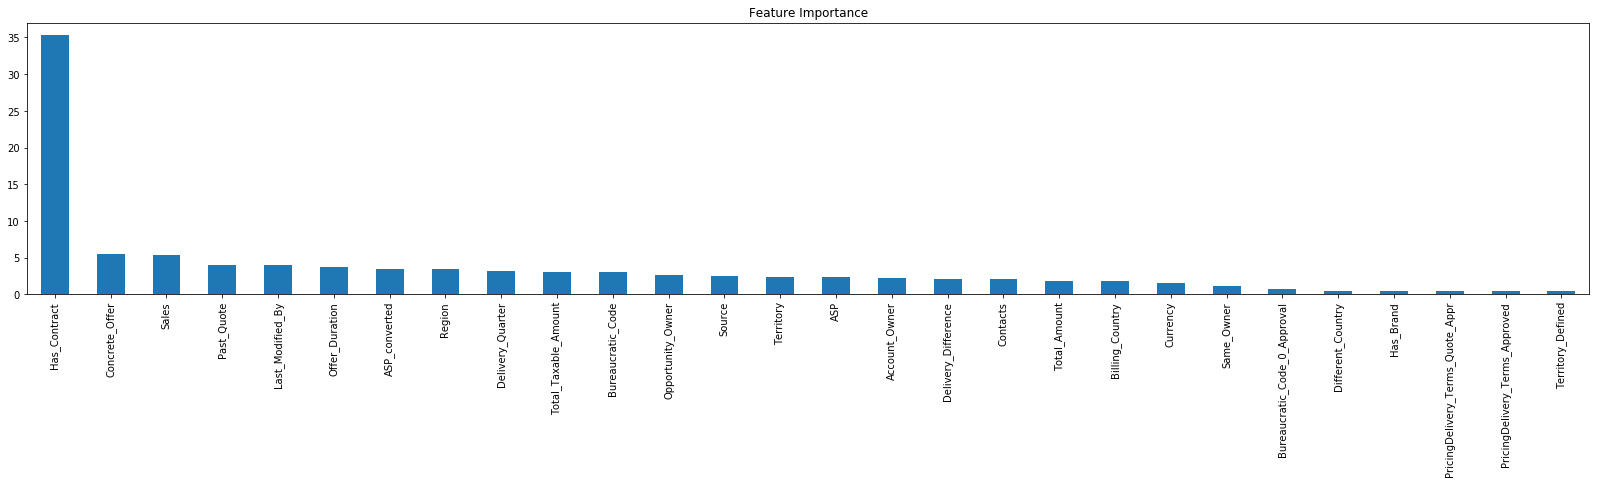

In [69]:
predictors = [x for x in x_train.drop(target, axis = 1).columns]
feat_imp = pd.Series(model.feature_importances_, predictors).sort_values(ascending = False)
feat_imp = feat_imp[0:28]
plt.rcParams['figure.figsize'] = 28, 5
feat_imp.plot(kind = 'bar', title = 'Feature Importance')

In [70]:
bad = x_test_pred[(x_test_pred.Prediction > 0.5) & (x_test_pred.Stage == 0) | (x_test_pred.Prediction < 0.5) & (x_test_pred.Stage == 1)]

In [71]:
bad

,Region,Territory,PricingDelivery_Terms_Quote_Appr,PricingDelivery_Terms_Approved,Bureaucratic_Code_0_Approval,Bureaucratic_Code_0_Approved,Bureaucratic_Code,Source,Billing_Country,Opportunity_ID,Sales_Contract_No,Account_Owner,Opportunity_Owner,Currency,Last_Modified_By,ASP,ASP_converted,Delivery_Quarter,Total_Amount,Total_Taxable_Amount,Stage,Contacts,Delivery_Difference,Same_Owner,Has_Brand,Has_Contract,Different_Country,TRF_Cat,Sales,Concrete_Offer,Offer_Duration,Territory_Defined,Past_Quote,Prediction
7812,APAC,Australia,1,0,1,0,Bureaucratic_Code_5,None,Australia,4832,2252,Person_Name_43,Person_Name_19,None,Person_Name_47,0.5400,0.38211,Q4,109620.00,109620.00,0,1,7.0,False,False,True,False,0.0,317,181.0,130.0,True,131.0,0.980531
4773,APAC,India,1,1,1,1,Bureaucratic_Code_4,Source_13,Sri Lanka,2824,904,Person_Name_49,Person_Name_49,None,Person_Name_47,0.3600,0.36000,Q4,157172.40,157172.40,0,1,19.0,False,False,True,True,0.0,31,72.0,72.0,True,-27.0,0.997332
9800,APAC,Thailand,0,0,0,0,Bureaucratic_Code_4,Source_7,Thailand,6207,3436,Person_Name_54,Person_Name_54,None,Person_Name_47,0.4000,0.40000,Q4,120060.00,120060.00,0,1,0.0,False,False,True,False,0.0,1,86.0,57.0,True,70.0,0.980919
952,EMEA,Germany,1,0,0,0,Bureaucratic_Code_5,Source_7,Germany,511,1344,Person_Name_4,Person_Name_4,None,Person_Name_41,0.3875,0.43830,Q2,287525.00,287525.00,0,1,12.0,False,False,True,False,1.0,17,88.0,8.0,True,603.0,0.995271
16800,EMEA,None,0,0,0,0,Bureaucratic_Code_4,None,Luxembourg,12726,None,Person_Name_18,Person_Name_20,None,Person_Name_20,0.5400,0.61079,Q1,105300.00,105300.00,1,1,3.0,True,False,False,False,0.0,2,86.0,72.0,False,-8.0,0.055948
9280,Americas,NW America,0,0,0,0,Bureaucratic_Code_4,None,United States,5834,2880,Person_Name_64,Person_Name_64,None,Person_Name_47,0.4300,0.43000,Q4,30702.00,30702.00,0,1,0.0,False,False,True,True,0.0,22,132.0,4.0,True,183.0,0.694180
10407,Americas,None,1,0,0,0,Bureaucratic_Code_5,Source_7,United States,6515,3390,Person_Name_33,Person_Name_33,None,Person_Name_47,0.4950,0.49500,Q1,285862.50,285862.50,0,1,30.0,False,False,True,False,1.0,73,89.0,NaN,False,NaN,0.989326
15533,EMEA,Germany,1,1,1,1,Bureaucratic_Code_4,Source_7,Germany,9934,None,Person_Name_62,Person_Name_62,None,Person_Name_62,0.2300,0.26015,Q4,10666.25,10666.25,1,1,2.0,True,False,False,False,0.0,39,6.0,NaN,True,NaN,0.393867
7806,APAC,Australia,1,1,1,1,Bureaucratic_Code_4,None,Australia,4826,2247,Person_Name_43,Person_Name_19,None,Person_Name_47,0.5400,0.38211,Q4,109620.00,109620.00,0,1,7.0,False,False,True,False,0.0,317,181.0,130.0,True,131.0,0.860058
2607,EMEA,France,1,0,0,0,Bureaucratic_Code_5,None,France,1451,337,Person_Name_16,Person_Name_16,None,Person_Name_47,0.5050,0.57120,Q3,254267.50,507020.00,0,2,7.0,False,False,True,False,1.0,6,186.0,67.0,True,181.0,0.506957


In [72]:
bad.Stage.value_counts()

0    80
1    19
Name: Stage, dtype: int64

In [73]:
validation_file = "Validacion_ECI_2020.csv"
vali = pd.read_csv(validation_file)
validation = preprocess(vali)
leak = ["Opportunity_ID", "Sales_Contract_No"]
pred = model.predict_proba(validation.drop(leak, axis = 1))[:,1]

# agrupo por Opportunity_ID para dar una sola prediccion por solicitud

pred = pd.DataFrame(pred, index = validation.index, columns = ["Prediction"])
validation = validation.join(pred)

answer = pd.DataFrame(validation.groupby("Opportunity_ID", as_index = False)["Prediction"].mean())

In [83]:
prev = pd.read_csv("acceptable/submission_23.csv", names=["Opportunity_ID", "Prediction"])
prev["Prediction"].corr(answer["Prediction"])

0.9969324639435755

In [84]:
prev = pd.read_csv("acceptable/submission_11.csv")
prev["Prediction"].corr(answer["Prediction"])

0.9930115701820413

In [86]:
answer.to_csv("acceptable/submission_24.csv", header = False, index = False)

In [76]:
#p = prev.merge(answer, on = "Opportunity_ID")

In [77]:
#p["New_Prediction"] = (p.Prediction_x + p.Prediction_y) / 2.0

In [78]:
#pp = p[["Opportunity_ID", "New_Prediction"]]
#pp.to_csv("submission_24.csv", header = False, index = False)